In [105]:
import numpy as np
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

%matplotlib inline
images = []
steering_angles = []

In [199]:
images_orig = []
steering_angles_orig = []
steering_angles_all = []

for d in ["driving_data_1", "driving_data_2", "driving_data_3","driving_data_4","driving_data_5"] :
    csvfile = open("/home/dk/Downloads/"+d+"/driving_log.csv")
    reader = csv.reader(csvfile)
    for line in reader:
        angle = float(line[3])
        steering_angles_all.append(angle)
            
        #filter out 2/3 of very small steering angles
        if angle > -0.001 and angle < 0.001:
            if np.random.randint(0,3) is not 0:
                continue
            
        im = mpimg.imread(line[0].strip())
        images_orig.append(im)
        steering_angles_orig.append(angle)
            
        #don't use left and right camera images for small steering angle images
        if angle > -0.001 and angle < 0.001:
            continue
        
        im = mpimg.imread(line[1].strip())
        images_orig.append(im)
        steering_angles_orig.append(angle - 0.25)
            
        im = mpimg.imread(line[2].strip())
        images_orig.append(im)
        steering_angles_orig.append(angle + 0.25)
        
print("Number of images", len(images_orig))
print("Image dimension", images_orig[0].shape)
#print("Steering angle", steering_angles_orig[0])

Number of images 8572
Image dimension (160, 320, 3)


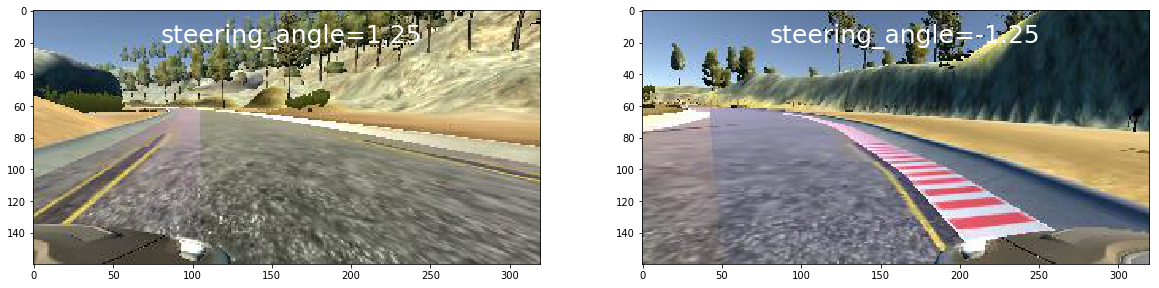

In [216]:
#vizualization of sharp turns
min_steering = np.min(steering_angles_orig)
max_steering = np.max(steering_angles_orig)

idx_min = np.where(steering_angles_orig == min_steering)[0][0]
idx_max = np.where(steering_angles_orig == max_steering)[0][0]

_, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
#ax1.subplot(1, 2, 1)
ax1.text(80,20,"steering_angle="+str(max_steering),color='white', fontsize='25')
ax1.imshow(images_orig[idx_max])

#ax2.subplot(1, 2, 2)
ax2.text(80,20,"steering_angle="+str(min_steering),color='white', fontsize='25')
ax2.imshow(images_orig[idx_min])
plt.show()


In [205]:
#images = np.array(np.array(images_orig)[:,70:-30,])
images = np.array(images_orig)
steering_angles = np.array(steering_angles_orig)

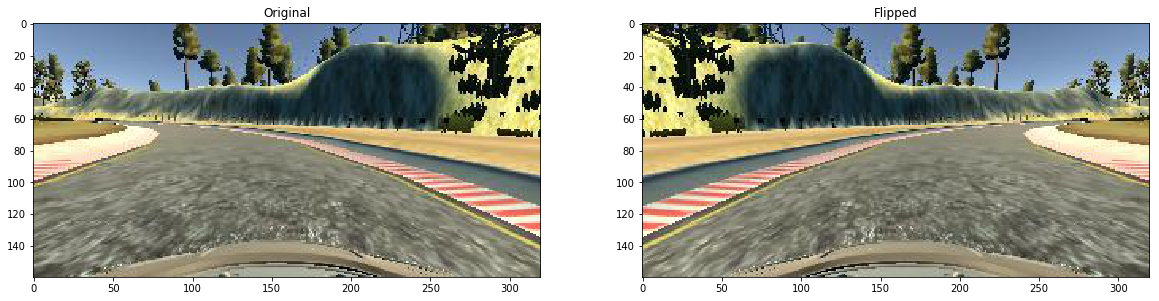

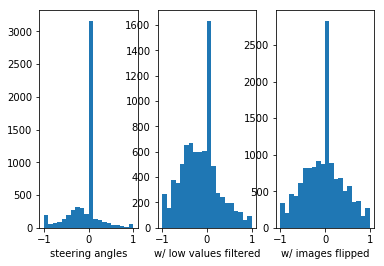

Number of images after augmentation 14211


In [215]:
#print("Images before flipping", images.shape)
coin_toss = np.random.randint(0,3,images.shape[0])
images_flipped = np.empty([np.count_nonzero(coin_toss),160,320,3], dtype=images.dtype)
steering_angles_flipped = np.empty(np.count_nonzero(coin_toss), steering_angles.dtype)

#Flip images randomly with a probablity of 0.5
j = 0
for i, h_t in enumerate(coin_toss):
    if h_t == 0:
        continue
    #print(i,j)
    images_flipped[j] = images[i]
    #print(images[i][0][0], images_flipped[j][0][0])
    steering_angles_flipped[j] = steering_angles[i]
    j = j+1
    
_, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(images_flipped[0])
ax1.set_title('Original')
images_flipped = np.flip(images_flipped, 2)
steering_angles_flipped = -1.0*steering_angles_flipped
ax2.set_title('Flipped')
ax2.imshow(images_flipped[0])
plt.show()

#data augmentation
images_aug = np.concatenate((images,images_flipped), axis=0)
steering_angles_aug = np.concatenate((steering_angles, steering_angles_flipped), axis=0)

plt.subplot(1, 3, 1)
plt.hist(steering_angles_all,bins=20, range=(-1.0,1.0))
plt.xlabel('steering angles')

plt.subplot(1, 3, 2)
plt.hist(steering_angles_orig,bins=20, range=(-1.0,1.0))
plt.xlabel('w/ low values filtered')

plt.subplot(1, 3, 3)
plt.xlabel('w/ images flipped')
plt.hist(steering_angles_aug,bins=20, range=(-1.0,1.0))
plt.show()
print("Number of images after augmentation", len(images_aug))

In [219]:
x = images_aug
y_ = steering_angles_aug

print(x.shape)
print(y_.shape)
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((70,30), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(60,320,3)))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(x, y_,batch_size=32,validation_split=0.2, shuffle=True, nb_epoch=2)

model.save('model_dk.h5')

(14211, 160, 320, 3)
(14211,)


/home/dk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
/home/dk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
/home/dk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 11368 samples, validate on 2843 samples
Epoch 1/2
11368/11368 [==============================] - 131s - loss: 0.1776 - val_loss: 0.2338